# part 1


In [ ]:
!pip install opendatasets
!pip install playsound
!pip install pydub
!pip install textgrid

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=8fb66b395a7aded9a8e09d0cbfdacf507190724f26a29b1f3c6cd3bd8729359f
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


In [ ]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/lazyrac00n/speech-activity-detection-datasets")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gotenkson
Your Kaggle Key: ··········


100%|██████████| 138M/138M [00:01<00:00, 119MB/s]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [ ]:
import wave
import librosa
import soundfile as sf
import librosa.display
from playsound import playsound
from audioread import audio_open

In [ ]:
import os
import glob
from pydub import AudioSegment
from textgrid import TextGrid

In [ ]:
folder_path = "/content/speech-activity-detection-datasets/Data/Audio/Female/TMIT"
time_path = "/content/speech-activity-detection-datasets/Data/Annotation/Female/TMIT"
file_list = os.listdir(folder_path)

full_file_paths = [os.path.join(folder_path, file_name) for file_name in file_list]
full_time_lists = [os.path.join(time_path, file_name[:-4]+'.TextGrid') for file_name in file_list]

audio_dataset = []
labels = []

sr = 0
for ind ,aud_name in enumerate(full_file_paths):
  audio,sr = librosa.load(aud_name)
  tg = TextGrid.fromFile(full_time_lists[ind])
  audio_dataset.append(audio)
  labels.append(tg)
  if ind == 50:
    break

In [ ]:
folder_path = "/content/speech-activity-detection-datasets/Data/Audio/Male/TMIT"
time_path = "/content/speech-activity-detection-datasets/Data/Annotation/Male/TMIT"
file_list = os.listdir(folder_path)

full_file_paths = [os.path.join(folder_path, file_name) for file_name in file_list]
full_time_lists = [os.path.join(time_path, file_name[:-4]+'.TextGrid') for file_name in file_list]

sr = 0
for ind ,aud_name in enumerate(full_file_paths):
  audio,sr = librosa.load(aud_name)
  tg = TextGrid.fromFile(full_time_lists[ind])
  audio_dataset.append(audio)
  labels.append(tg)
  if ind == 50:
    break

x_train = np.array(audio_dataset)

<ipython-input-9-d8d3362840c0>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(audio_dataset)


In [ ]:
np.shape(labels)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(102, 1)

In [ ]:
from scipy import interpolate
mel_x_train = []  # Initialize an empty list to store the Mel spectrograms

for ind, audio in enumerate(audio_dataset):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_x_train.append(mel_spectrogram)

In [ ]:
from scipy.interpolate import interp1d
y_train = []
for tg in labels:
  lab = []
  for tier in tg:
    for interval in tier:
      if interval.mark == '1':
        #int values of interval
        lab.append(np.array([interval.minTime,interval.maxTime]))
  y_train.append(lab)

def create_binary_labels(y_train, sr):
    binary_labels = []
    for ind, intervals in enumerate(y_train):
        audio_length = len(audio_dataset[ind])
        labels = np.zeros(audio_length)  # Initialize with zeros
        for interval in intervals:
            start_frame = int(interval[0] * sr)
            end_frame = int(interval[1] * sr)
            labels[start_frame:end_frame] = 1  # Set the corresponding frames to 1
        binary_labels.append(labels)
    return binary_labels

# Create binary labels for training data
bin_y_train = create_binary_labels(y_train, sr)

def compress_binary_labels(binary_labels, mel_x_train):
    compressed_labels = []
    for ind, binary_label in enumerate(binary_labels):
        mel_spectrogram_shape = np.shape(mel_x_train[ind])
        # Create an interpolation function for the binary label
        x = np.linspace(0, 1, len(binary_label))  # Assuming binary_label covers the full audio duration (0 to 1)
        f = interp1d(x, binary_label, kind='linear', fill_value='extrapolate')

        # Use the interpolation function to resample the binary label
        new_x = np.linspace(0, 1, mel_spectrogram_shape[1])  # Use the number of columns from the Mel spectrogram
        compressed_label = f(new_x)
        compressed_labels.append(compressed_label)

    return compressed_labels

binary_y_train = compress_binary_labels(bin_y_train, mel_x_train)

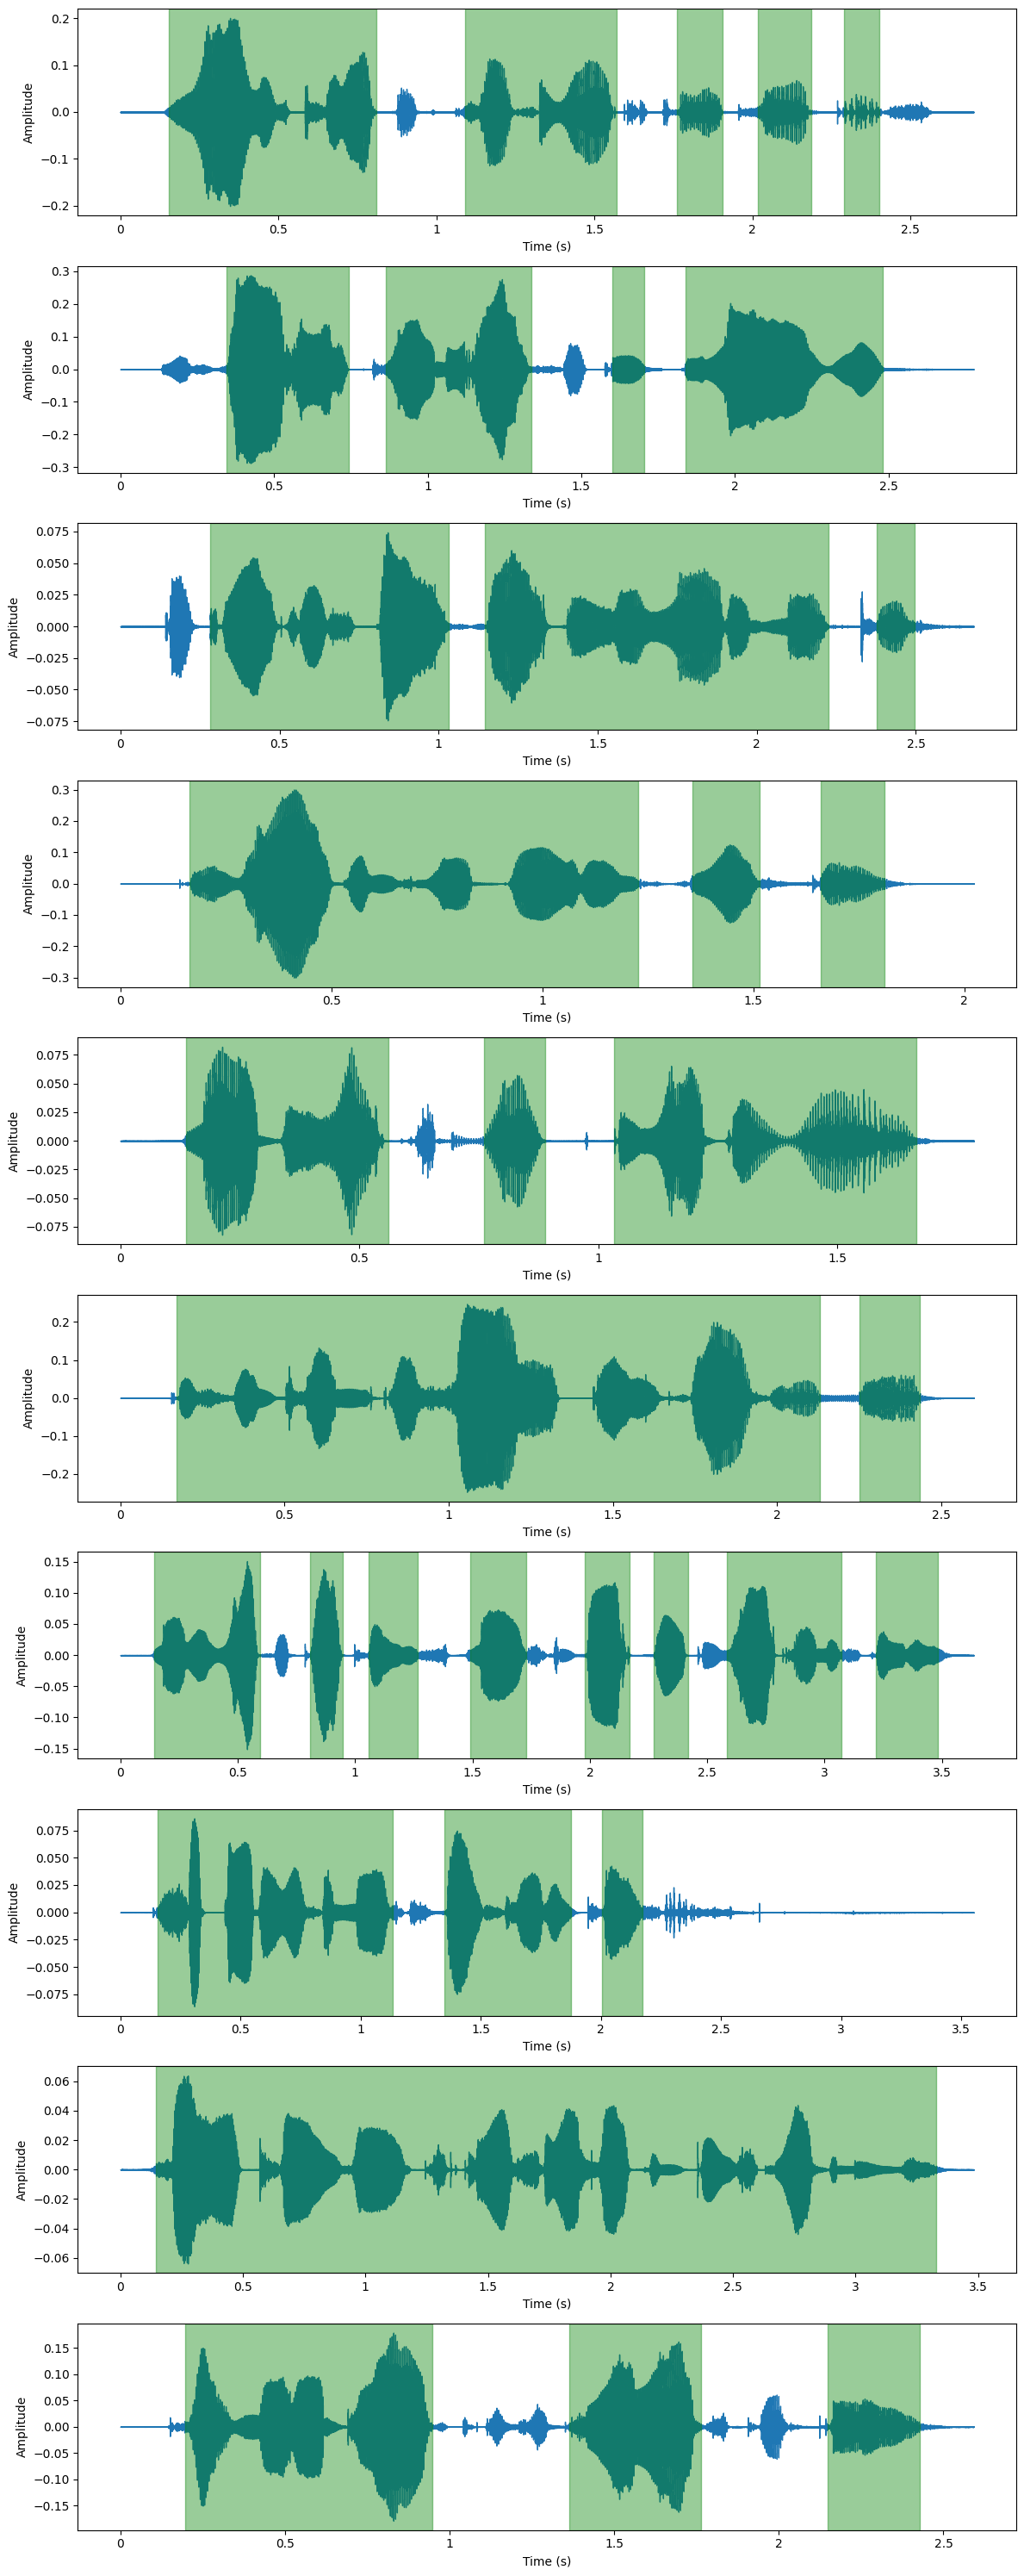

In [ ]:
plt.figure(figsize = (12,30))
for ind, (audio, tg) in enumerate(zip(audio_dataset[:10], labels[:10])):
    plt.subplot(10, 1, ind + 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    for tier in tg:
        for interval in tier:
            start_time = interval.minTime
            end_time = interval.maxTime

            # Check if the 3rd parameter (tier.mark) is equal to 1
            if interval.mark == '1':
                # Convert start and end times to sample indices
                start_sample = int(start_time * sr)
                end_sample = int(end_time * sr)

                # Highlight the segment on the plot
                plt.axvspan(xmin=start_sample / sr, xmax=end_sample / sr, color='g', alpha=0.4)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

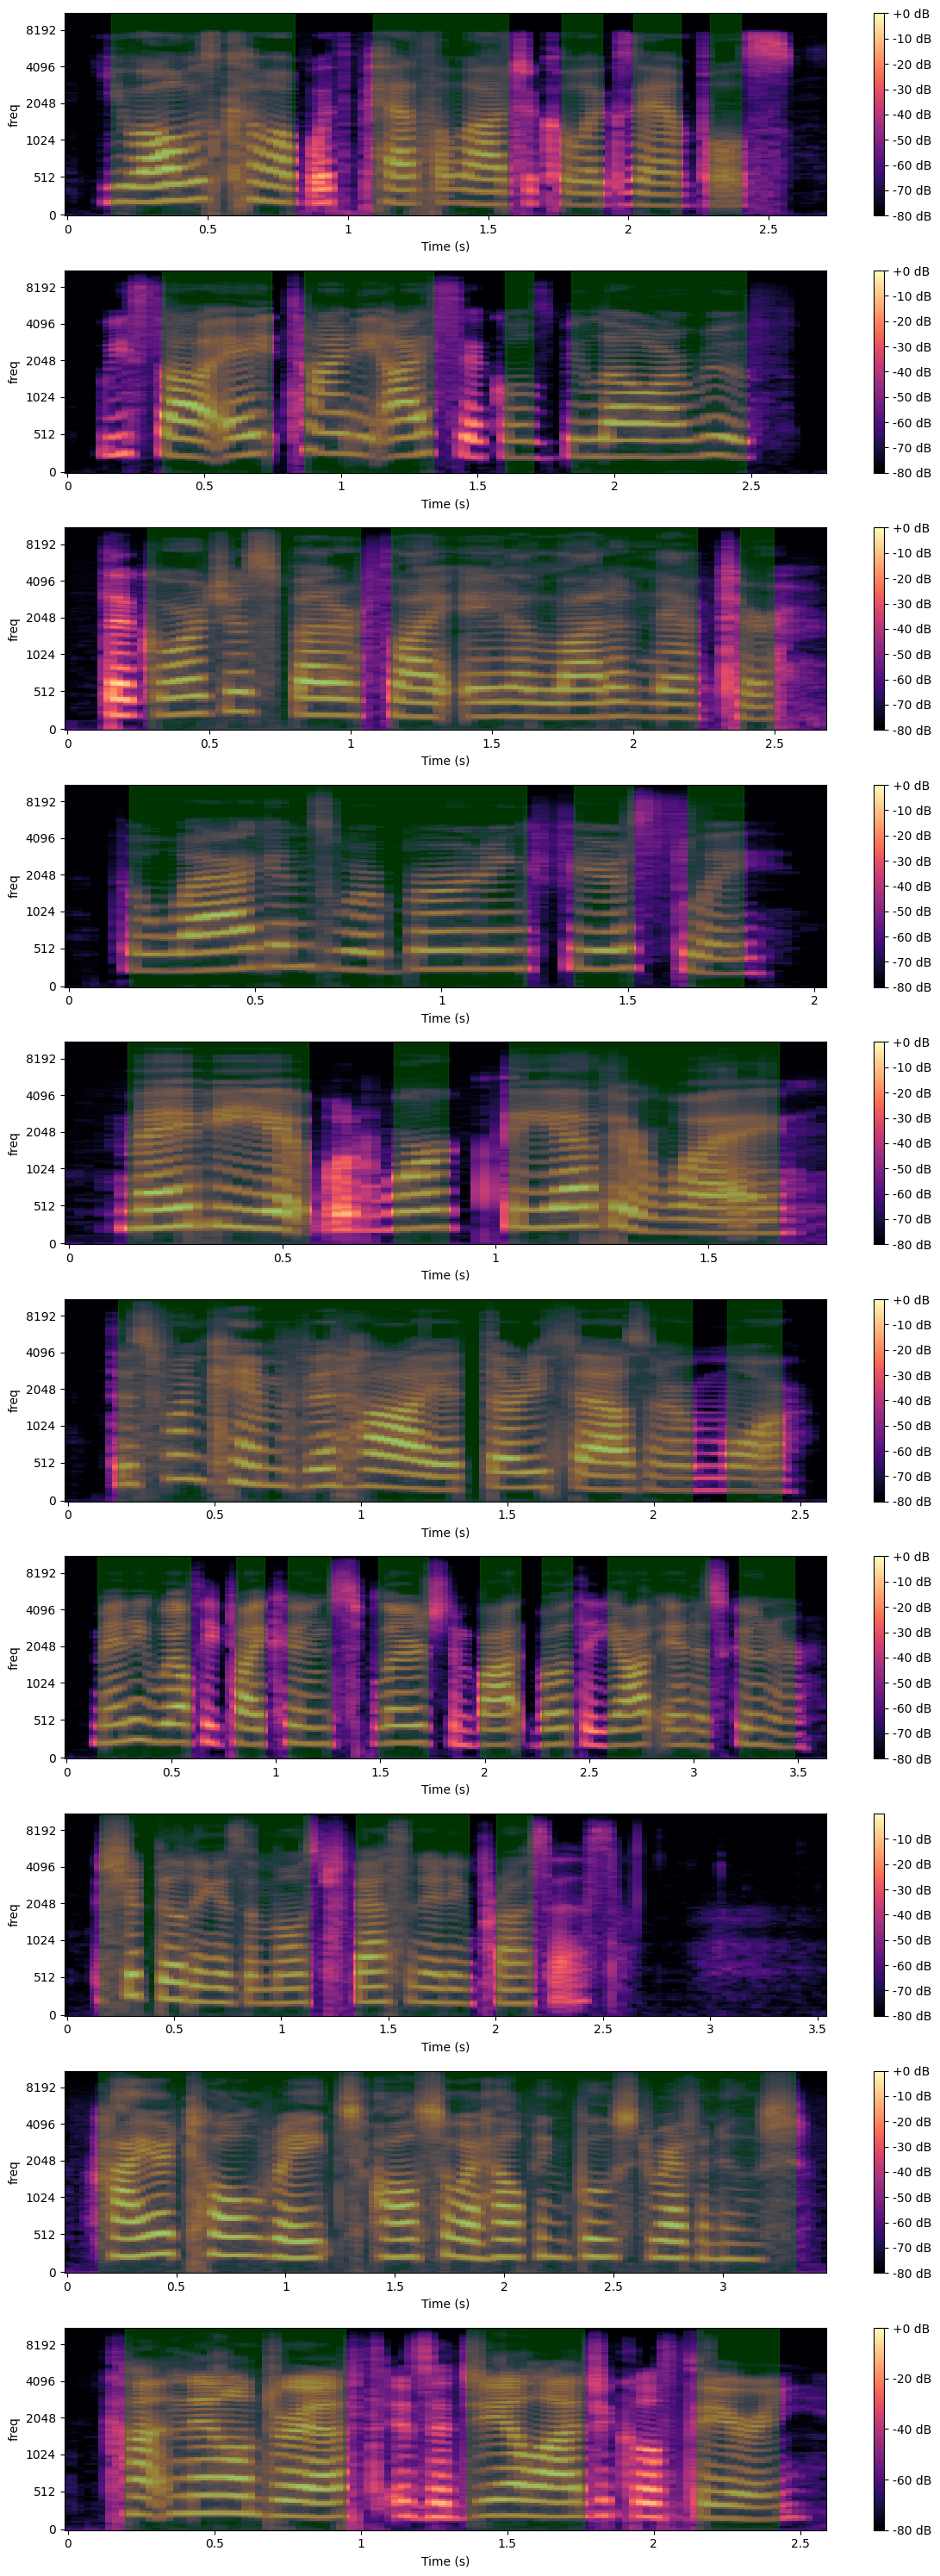

In [ ]:
hop_length = 512  # Adjust as needed
n_fft = 2048  # Adjust as needed
spectrogram = np.abs(librosa.stft(audio, hop_length=hop_length, n_fft=n_fft))
plt.figure(figsize = (12,30))
for ind, (audio, tg) in enumerate(zip(audio_dataset[:10], labels[:10])):
    plt.subplot(10, 1, ind + 1)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=512, n_fft=2048)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('freq')

    for tier in tg:
        for interval in tier:
            start_time = interval.minTime
            end_time = interval.maxTime

            # Check if the 3rd parameter (tier.mark) is equal to 1
            if interval.mark == '1':
                # Convert start and end times to sample indices
                start_sample = int(start_time * sr)
                end_sample = int(end_time * sr)

                # Highlight the segment on the plot
                plt.axvspan(xmin=start_sample / sr, xmax=end_sample / sr, color='g', alpha=0.4)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# part 2

In [ ]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 1)))

    model.add(layers.Reshape((-1,256)))

    model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True)))
    model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True)))

    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))


    return model

In [ ]:
input_shape = (128, None, 1)

# Build the model
cnn_model = build_model(input_shape)
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 128, None, 128)    1280      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 64, None, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 64, None, 128)     147584    
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 32, None, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 32, None, 128)     147584    
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 16, None, 128)  

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score

# Define a custom F1 score metric
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return f1_score(y_true, y_pred, average='samples')

# Assuming you have your model, input_shape, and other parameters defined
input_shape = (128, None, 1)
cnn_model = build_model(input_shape)

# Define training parameters
batch_size = 2
epochs = 2

# Compile the model with binary cross-entropy loss and custom F1 score metric
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

num_examples = len(mel_x_train)
shuffled_indices = np.arange(num_examples - 1)
np.random.shuffle(shuffled_indices)

# Loop through each example in mel_x_train and binary_y_train
for i in range(len(mel_x_train)):
    idx = shuffled_indices[i]
    mel_x_example = mel_x_train[idx:idx + 1]  # Extract one example
    binary_y_example = binary_y_train[idx:idx + 1]  # Extract corresponding labels

    mel_x_example = tf.convert_to_tensor(mel_x_example, dtype=tf.float32)
    binary_y_example = tf.convert_to_tensor(binary_y_example, dtype=tf.float32)

    # Train the model with the current example
    history = cnn_model.fit(mel_x_example, binary_y_example, batch_size=batch_size, epochs=epochs, verbose=1)
    if i == 80:
        break


Epoch 1/2
1/1 [==============================] - 14s 14s/step - loss: 0.6932 - accuracy: 0.3988
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 0.6731 - accuracy: 0.7500
Epoch 1/2
1/1 [==============================] - 9s 9s/step - loss: 0.7007 - accuracy: 0.4706
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 0.6548 - accuracy: 0.4706
Epoch 1/2
1/1 [==============================] - 1s 741ms/step - loss: 0.5594 - accuracy: 0.7636
Epoch 2/2
1/1 [==============================] - 0s 467ms/step - loss: 0.5192 - accuracy: 0.7636
Epoch 1/2
1/1 [==============================] - 1s 570ms/step - loss: 0.6922 - accuracy: 0.5985
Epoch 2/2
1/1 [==============================] - 1s 550ms/step - loss: 0.6479 - accuracy: 0.6061
Epoch 1/2
1/1 [==============================] - 1s 565ms/step - loss: 0.5226 - accuracy: 0.7687
Epoch 2/2
1/1 [==============================] - 1s 592ms/step - loss: 0.5149 - accuracy: 0.7836
Epoch 1/2
1/1 [=========================

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=512, n_fft=2048)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('freq')

for tier in tg:
  for interval in tier:
    start_time = interval.minTime
    end_time = interval.maxTime

    # Check if the 3rd parameter (tier.mark) is equal to 1
    if interval.mark == '1':
        # Convert start and end times to sample indices
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        # Highlight the segment on the plot
        plt.axvspan(xmin=start_sample / sr, xmax=end_sample / sr, color='g', alpha=0.4)

In [ ]:
def expand_binary_label_tf(compressed_label, threshold=0.5):
    intervals = []
    in_interval = False
    start_time = 0  # Remove singleton dimensions
    for i, value in enumerate(compressed_label):
        if value >= threshold and not in_interval:
            in_interval = True
            start_time = i / len(compressed_label)
        elif value < threshold and in_interval:
            in_interval = False
            end_time = i / len(compressed_label)
            intervals.append((start_time, end_time))
    # Check if an interval is open when reaching the end of the signal
    if in_interval:
        end_time = 1.0
        intervals.append((start_time, end_time))
    return intervals

In [ ]:
def expand_binary_label(time, compressed_label, threshold=0.5):
    intervals = []
    in_interval = False
    start_time = 0
    duration = time  # Assuming time corresponds to the duration of the audio
    for i, value in enumerate(compressed_label):
        time_point = i / len(compressed_label) * duration
        if value >= threshold and not in_interval:
            in_interval = True
            start_time = time_point
        elif value < threshold and in_interval:
            in_interval = False
            end_time = time_point
            intervals.append((start_time, end_time))
    # Check if an interval is open when reaching the end of the signal
    if in_interval:
        end_time = duration
        intervals.append((start_time, end_time))
    return intervals

In [ ]:
predicted_compressed_label = cnn_model.predict(mel_x_example)

1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 144ms/step


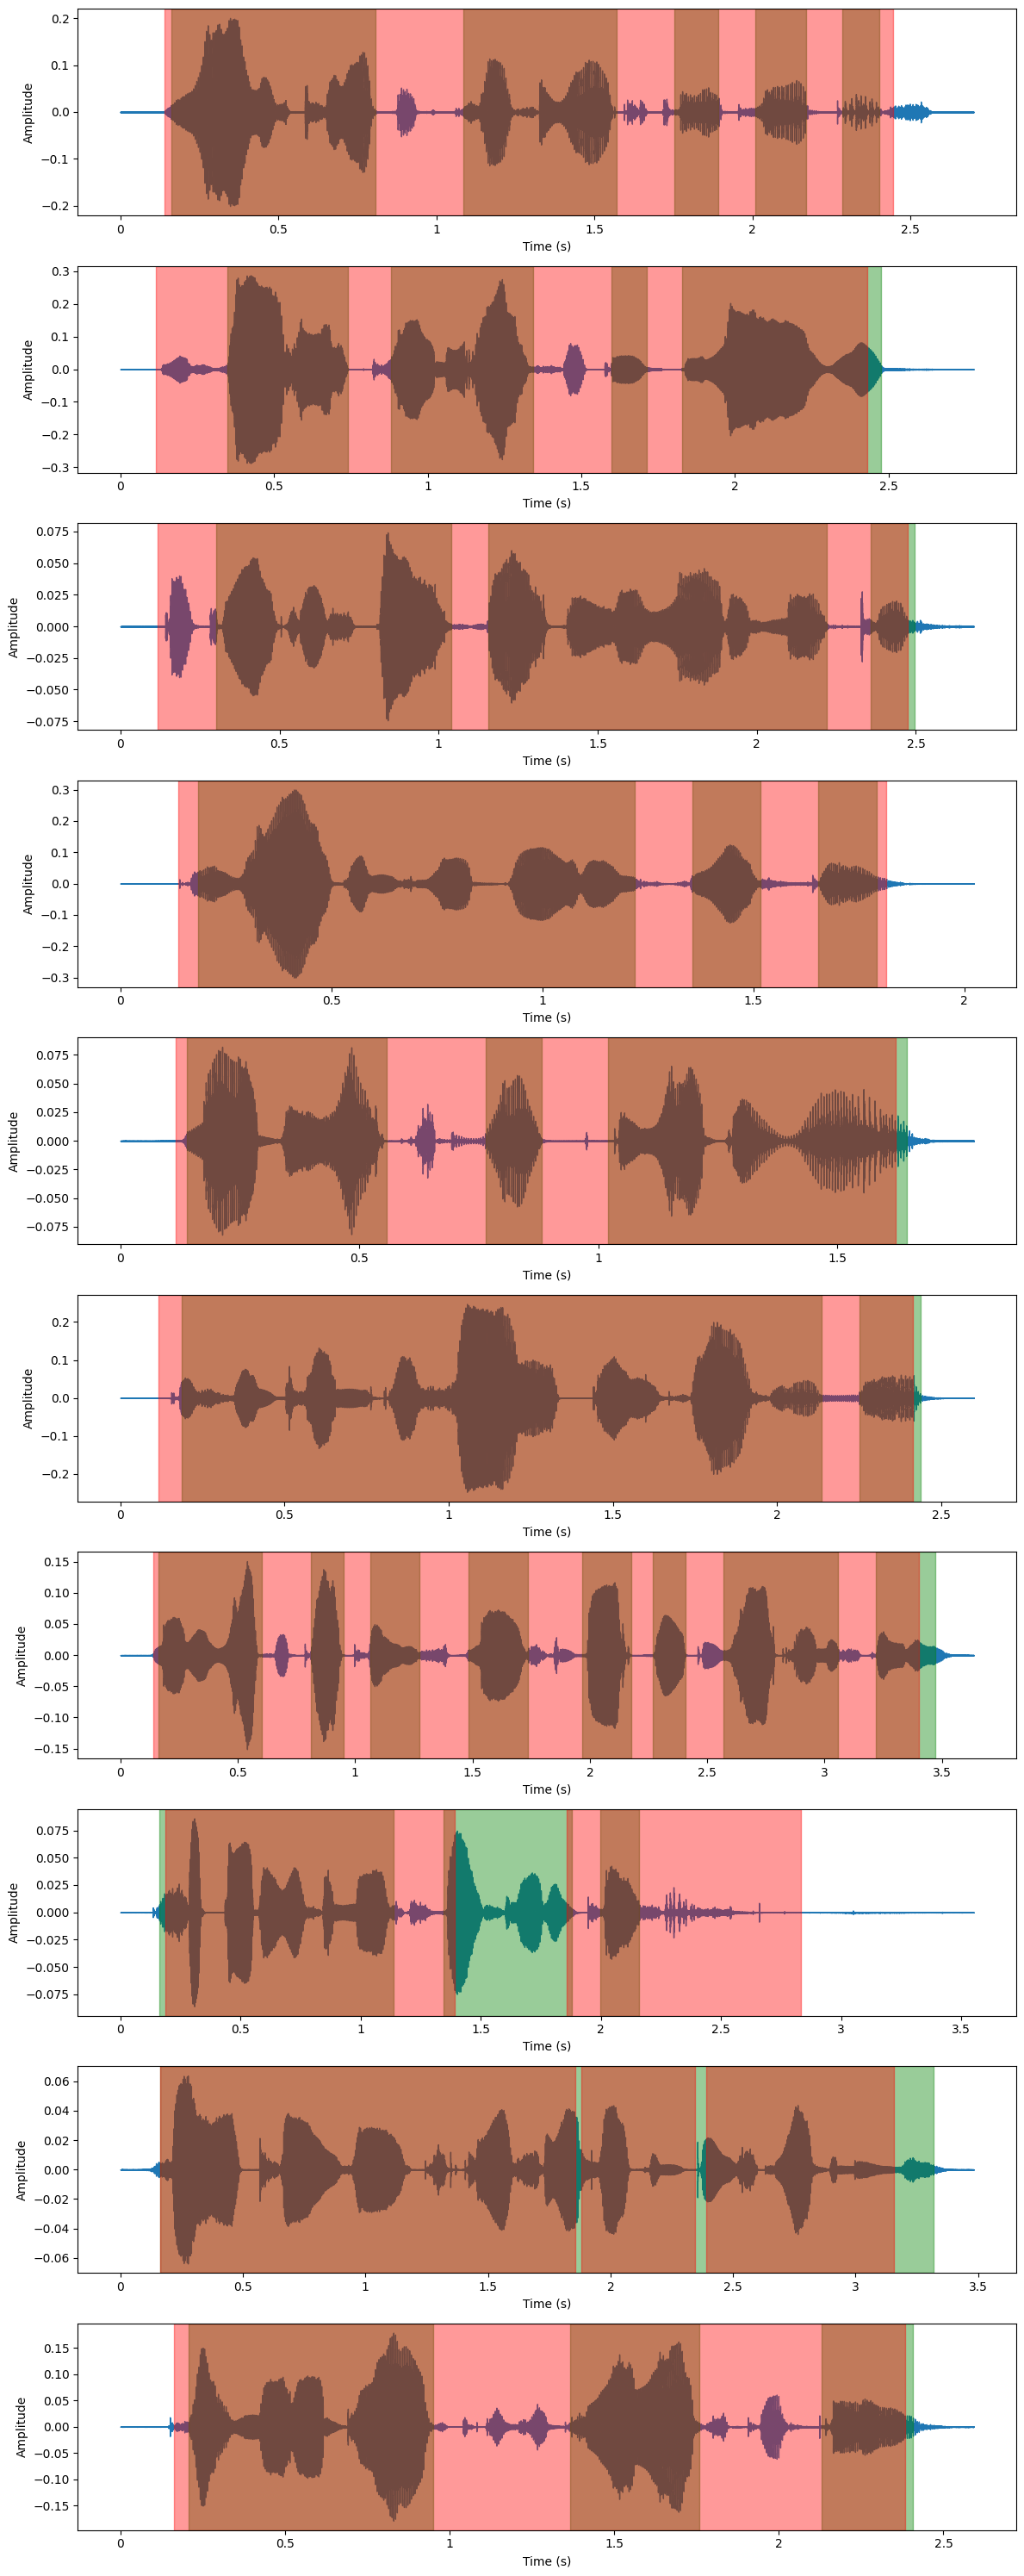

In [ ]:
plt.figure(figsize = (12,30))
for i in range(10):
    mel_x_example = mel_x_train[i:i+1]
    binary_y_example = binary_y_train[i:i+1]
    binary_y_example_np = np.array(binary_y_example)
    binary_y_example_np = binary_y_example_np.squeeze(axis=0)
    duration = librosa.get_duration(y=audio_dataset[i], sr=sr)

    mel_x_example = tf.convert_to_tensor(mel_x_example, dtype=tf.float32)

    predicted_compressed_label = cnn_model.predict(mel_x_example)
    predicted_compressed_label = predicted_compressed_label.squeeze(axis=(0, 2))

    predicted_intervals = expand_binary_label(duration ,predicted_compressed_label, threshold=0.7)
    true_intervals = expand_binary_label(duration ,binary_y_example_np, threshold=0.5)

    plt.subplot(10, 1, i + 1)
    librosa.display.waveshow(audio_dataset[i], sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    for start_time, end_time in true_intervals:
        plt.axvspan(xmin=start_time, xmax=end_time, color='g', alpha=0.4, label='True Interval')
    for start_time, end_time in predicted_intervals:
        plt.axvspan(xmin=start_time, xmax=end_time, color='r', alpha=0.4, label='Predicted Interval')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
np.shape(mel_spectrogram_ass4)

TensorShape([1, 128, 23285])

In [ ]:
aud_name = '/content/8janA_bg.wav'
audio_ass4,sr = librosa.load(aud_name)
duration = librosa.get_duration(y=audio_ass4, sr=sr)
mel_spectrogram_ass4 = librosa.feature.melspectrogram(y=audio_ass4, sr=sr)
mel_spectrogram_ass4 = np.expand_dims(mel_spectrogram_ass4,axis=0)

In [ ]:
mel_spectrogram_ass4 = tf.convert_to_tensor(mel_spectrogram_ass4, dtype=tf.float32)

predicted_compressed_label = cnn_model.predict(mel_spectrogram_ass4)
predicted_compressed_label = predicted_compressed_label.squeeze(axis=(0, 2))

predicted_intervals = expand_binary_label(duration ,predicted_compressed_label, threshold=0.7)

librosa.display.waveshow(audio_ass4, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

for start_time, end_time in predicted_intervals:
        plt.axvspan(xmin=start_time, xmax=end_time, color='r', alpha=0.4, label='Predicted Interval')

plt.show()

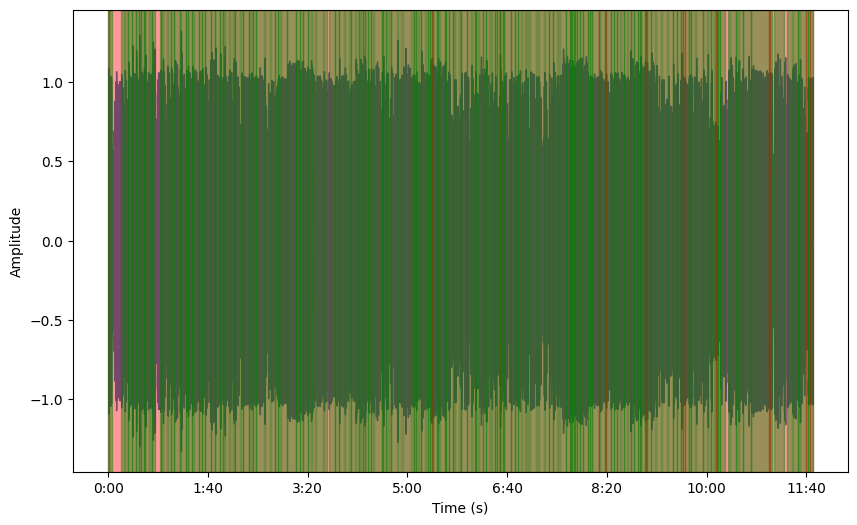

In [ ]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd

# Load the audio
aud_name = '/content/8janA_bg.wav'
audio_ass4, sr = librosa.load(aud_name)

# Get the duration of the audio
duration = librosa.get_duration(y=audio_ass4, sr=sr)

# Load timestamps from a CSV file (replace 'timestamps.csv' with your actual CSV file)
timestamps_df = pd.read_csv('/content/8janA_speech_timestamps.csv')

# Extract start and end times from the CSV file (adjust column names as needed)
csv_start_times = timestamps_df['start'].tolist()
csv_end_times = timestamps_df['end'].tolist()

# Predicted intervals (you can replace this with your predicted intervals)
predicted_intervals = expand_binary_label(duration, predicted_compressed_label, threshold=0.5)

# Plot the audio waveform
plt.figure(figsize=(10, 6))
librosa.display.waveshow(audio_ass4, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot predicted intervals in red
for start_time, end_time in predicted_intervals:
    plt.axvspan(xmin=start_time, xmax=end_time, color='r', alpha=0.4, label='Predicted Interval')

# Plot CSV timestamps in green
for start_time, end_time in zip(csv_start_times, csv_end_times):
    plt.axvspan(xmin=start_time, xmax=end_time, color='g', alpha=0.4, label='CSV Timestamp')

# Display legend
# Show the plot
plt.show()
